# Unupervised-Learning - Exercise Sheet 8

## Task 2

### 1. Sampeling

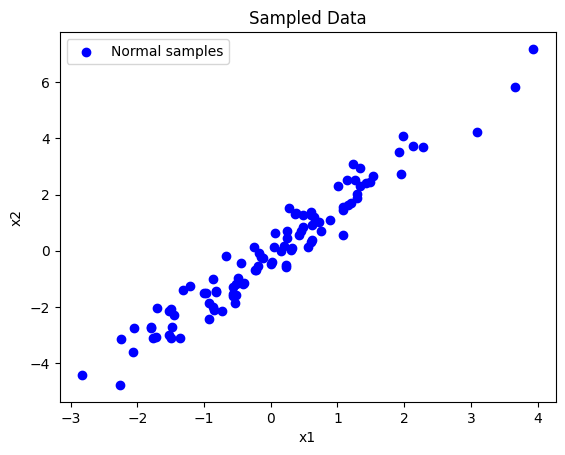

[0.06773457 7.38175517] [0.51399075 0.85779573]


In [ ]:
import numpy as np
from math import sqrt, cos, sin, radians
import matplotlib.pyplot as plt

#Building the covariance matrix
sigX2, sigY2 = 2, 1
rho = math.sqrt(3)/2
sigX, sigY = math.sqrt(sigX2), math.sqrt(sigY2)

Sigma = np.array([
    [sigX2, sigX2 + rho*sigX*sigY],
    [sigX2 + rho*sigX*sigY, sigX2 + sigY2 + 2*rho*sigX*sigY]
], dtype=float)

# since the mean is not specified we use (0,0) 
mean = np.array([0,0])
samples = np.random.multivariate_normal(mean, Sigma, size=100)

plt.scatter(samples[:,0], samples[:,1], color="blue", label="Normal samples")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Sampled Data")
plt.legend()
plt.show()

### 2. Calculate Eigenvector

In [10]:
eigvals, eigvecs = np.linalg.eigh(Sigma)   # ascending
v1 = eigvecs[:, 1]                         # largest eigenvalue
print(eigvals, v1)                         # v1 already normalized

[0.06773457 7.38175517] [0.51399075 0.85779573]


### 3. Add Outliers

In [ ]:
# --- chi^2 quantiles for df=2 (no scipy needed) ---
CHI2_DF2 = {
    0.99:  9.210340371976184,
    0.995: 10.596634733096073,
    0.999: 13.815510557964274
}

def rot(theta_deg: float) -> np.ndarray:
    t = radians(theta_deg)
    return np.array([[cos(t), -sin(t)],
                     [sin(t),  cos(t)]], dtype=float)

# --- matrix square root Sigma^(1/2) via eigen-decomposition ---
eigvals, eigvecs = np.linalg.eigh(SigmaXZ)
Sigma_sqrt = eigvecs @ np.diag(np.sqrt(eigvals)) @ eigvecs.T

outliers = []
for q in (0.99, 0.995, 0.999):
    c_q = CHI2_DF2[q]
    for theta in (+10.0, -10.0):
        u = rot(theta) @ v1
        u = u / np.linalg.norm(u)              # unit direction
        x_out = muXZ + sqrt(c_q) * (Sigma_sqrt @ u)
        outliers.append(x_out)

outliers = np.array(outliers)  # shape (6,2)